# Data gathering and preprocessing

This notebook is dedicated to data gathering and preprocessing. That is, with this notebook you'll be able to: download the data, unzip it (if necessary), and, finally, prepare the data for further vizualization and modeling.  

In this study, we used open data from the following sources:
1. London Datastore (London shape files);
2. Office for National Statistics (London population);
3. Transport for London (metro traffic);
4. Wikimedia Commons (metro station locations);
5. OpenStreetMaps (points of interest).

The links to the data sets can be found in the __References section__. Besides that, we used results from Verma et al. (2020). In this work, authors proposed spatio-temporal clustering of London metro stations based on their traffic. We will use results of this clustering in the second notebook.

To gather the data we used URL links to the websites of the data providers. Note, that the __data sets can be updated__ by corresponding agencies; therefore, some discrepancies are possible: new variables will become available, or some data set will have fewer attributes. To gather POIs data we used Python package OSMnx (Boeing, 2017).

The notebook is split into three sections: Data Gathering, Data Preprocessing and References. Each of the sections consists of subsections covering different data sets.

In [1]:
import requests, zipfile, io, os
from datetime import datetime
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from pyrosm import OSM
import shutil

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyrosm\utils\_compat.py:12: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). The tool will work but it runs a bit slower.
  shapely_geos_version, geos_capi_version_string


## 1. Data gathering

__London shape files__

In [4]:
url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

directory = "../data/raw/geometry/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

z.extractall(path=directory)
print(f'Downloading date: {datetime.today().strftime("%d-%m-%Y %H:%M:%S")}')

__London population__

In [5]:
url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fcensusoutputareaestimatesinthelondonregionofengland%2fmid2017/sape20dt10amid2017coaunformattedsyoaestimateslondon.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

directory = "../data/raw/population/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)
    
z.extractall(path=directory)
print(f'Downloading date: {datetime.today().strftime("%d-%m-%Y %H:%M:%S")}')

__OpenStreetMaps POIs__

In [10]:
%%time
url = 'https://download.geofabrik.de/europe/great-britain/england/greater-london-latest.osm.pbf'
r = requests.get(url)

directory = "../data/raw/pois/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)
    
with open(directory + 'greater-london-latest.osm.pbf', 'wb') as f:
    f.write(r.content)
print(f'Downloading date: {datetime.today().strftime("%d-%m-%Y %H:%M:%S")}')

Wall time: 7.49 s


In [11]:
%%time

# Initialize the OSM parser object
osm = OSM('../data/raw/pois/greater-london-latest.osm.pbf')

# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

Wall time: 27.4 s


Wall time: 16 ms


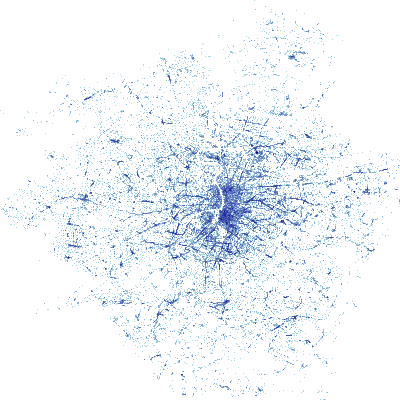

In [18]:
%%time
import datashader as ds, pandas as pd
import datashader.transfer_functions as tf

cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(pois, 'lat', 'lon')
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], how='log')
img

In [19]:
pois.shape

(112055, 108)

Wall time: 13.4 s


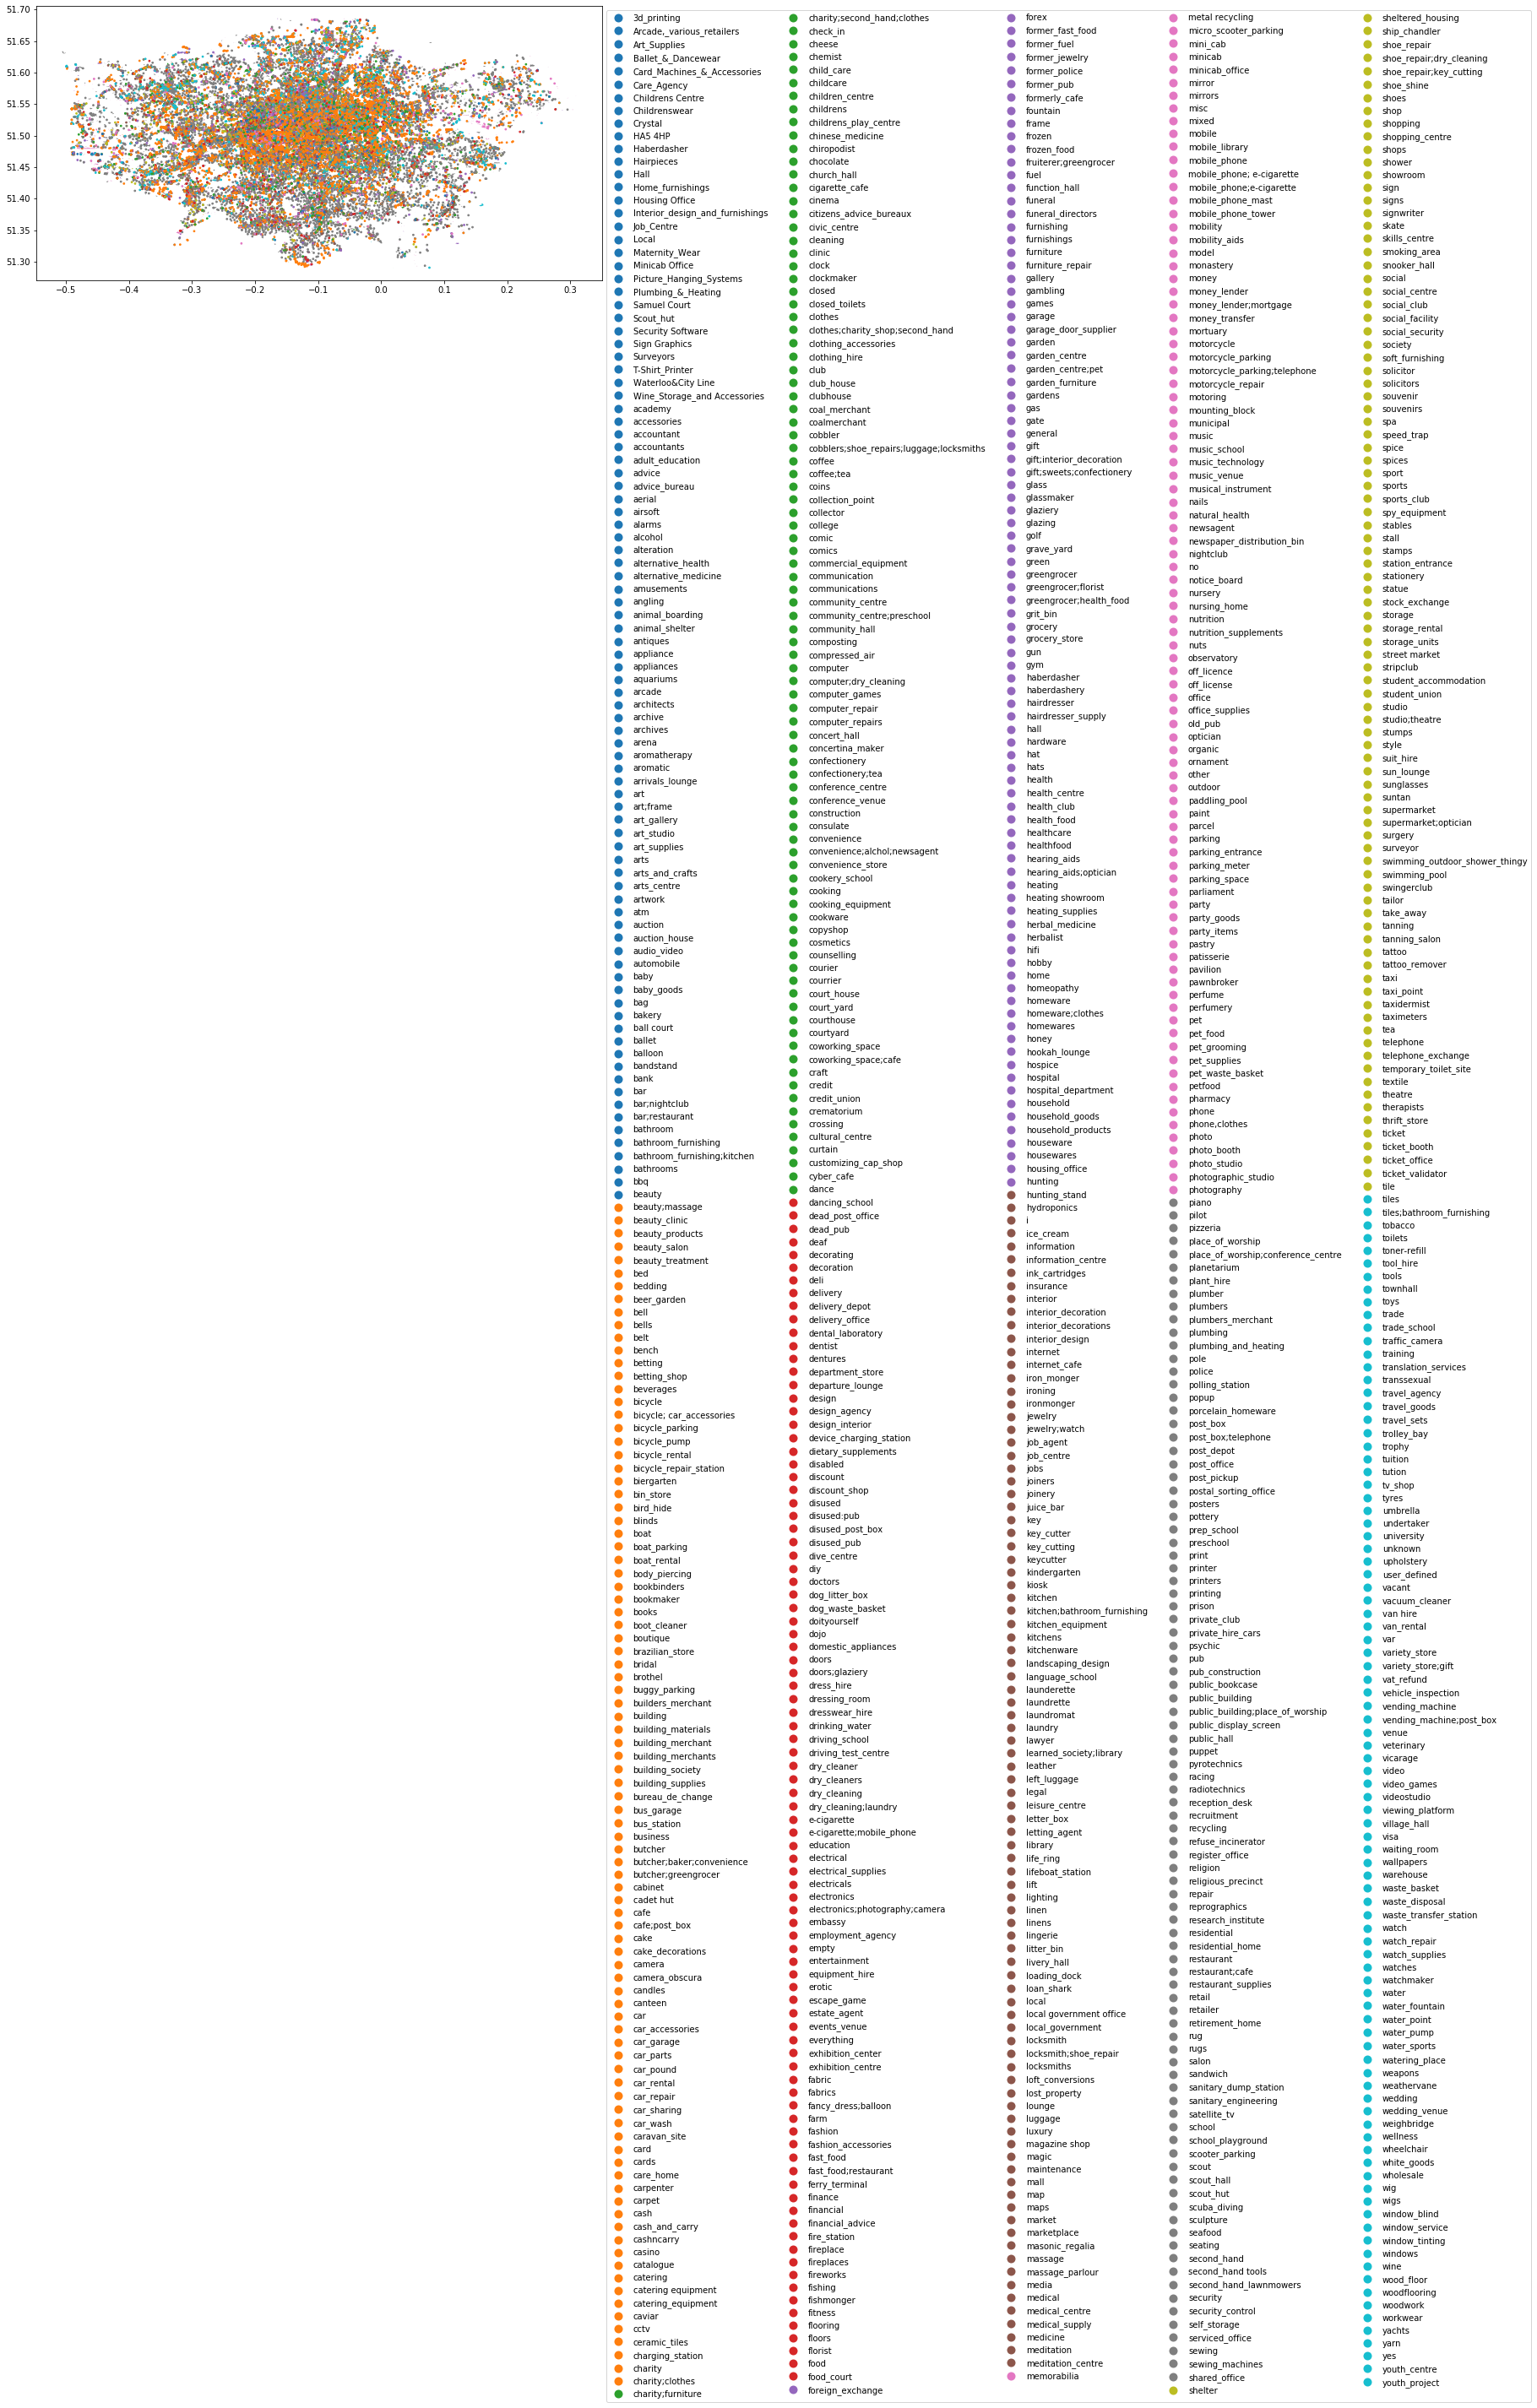

In [12]:
%%time
# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

In [9]:
directory = "../data/processed/pois/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

# Save complete data
pois.to_csv(directory + "pois.csv")

# Save only the columns of interest
# pois = pois[["osmid", "geometry", "amenity", "name", "building"]]
# pois.to_file(directory + "pois.json", driver="GeoJSON", encoding="utf-8")

## 2. Data preprocessing

__Connect shape files and population__

In [5]:
%%time
# Load population data
population = pd.read_excel("../data/raw/population/SAPE20DT10a-mid-2017-coa-unformatted-syoa-estimates-london.xlsx", 
                           sheet_name="Mid-2017 Persons", skiprows=4)  # the first 4 rows have irrelevant information, so skip them

# Rename a column
population.rename({"All Ages": "total_population"}, axis=1, inplace=True)

# Select only the age groups of interest
# The assumption is that only those people who are from the age of 18 to the age of 65 are working
age_groups = [age for age in range(18, 65)]

# Create adult population column
population["adult_population"] = population[age_groups].sum(axis=1)

Wall time: 1min 6s


In [6]:
# Merge geometry and population data, both boroughs and wards
merged = pd.merge(geometry, population[["OA11CD", "total_population", "adult_population"]], on="OA11CD")                            
boroughs = merged.dissolve("LAD11NM", aggfunc="sum", as_index=False)                            
wards = merged.dissolve("WD11CD_BF", aggfunc="sum", as_index=False)

# Define the directory to store the data
directory = "../data/processed/population/"

# Create it if needed
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)
                
# Save the data
boroughs.to_file(directory + 'boroughs.json', driver='GeoJSON')
wards.to_file(directory + 'wards.json', driver='GeoJSON')

__POIs__

In [20]:
# load POIs data
pois = pd.read_csv("data/raw/pois/pois.csv")
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois['lon'], pois['lat']))
pois.shape

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10,22,27,29,30,31,32,33,34,35,36,37,38,39,40,42,43,47,48,49,52,53,55,56,57,58,59,60,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,87,88,90,91,92,93,94,97,98,99,100,101,102,103,104,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(112043, 109)

Sometimes geometry of a POI is of _Multipolygon_ or _Polygon_ type. Let's convert it to _Point_ type for uniformity. 

In [17]:
# Change geometry
pois['geometry'] = pois['geometry'].apply(lambda x:x.centroid)

In "pois_categorization.csv" we introduced a __subjective categorization__ of POIs into a set of categories. Let's assign these categories to the POIs that we've collected.

In [22]:
# Load categories and merge them with POIs data
pois_categories = pd.read_csv("data/external/pois_categories.csv")
pois = pd.merge(pois, pois_categories, left_on='amenity', right_on="pois")
pois.drop('amenity', axis=1, inplace=True)

In [23]:
pois.shape

(81495, 110)

In [24]:
# Remove amenities tagged 'misc'
pois = pois[pois['pois_category'] != "misc"]

# Drop duplicated amenities
pois = pois.drop_duplicates(subset=["geometry", "name", "pois"]).reset_index(drop=True)

In [11]:
# Merge POIs with geometry
pois = gpd.sjoin(pois, geometry.to_crs(epsg=27700), how="inner", op="intersects")

In [12]:
# Get total counts of POIs types in each borough
# Boroughs are tagged LAD11NM
pois_counts = pois.groupby(['pois_category', 'LAD11NM']).agg(len)
pois_counts = pois_counts.reset_index()
pois_counts = pois_counts.pivot(index="pois_category", columns ="LAD11NM", values= "name")

In [13]:
# Define the directory to store the data
directory = "data/processed/pois/"

# Create it if needed
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

# Save the data
pois_counts.to_csv(directory + 'pois_counts.csv')

Succefully created new directory data/processed/pois/


## 3. References
1. London Datastore (2019). Statistical GIS Boundary Files for London. Retrieved from https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
2. Office for National Statistics (2019). Census Output Area population estimates – London, England (supporting information). Retrieved from https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/censusoutputareaestimatesinthelondonregionofengland
3. Transport for London (2020). Transport for London API. Retrieved from https://api-portal.tfl.gov.uk/docs
4. Wikimedia Commons (2020). London Underground geographic maps/CSV. Retrieved from https://commons.wikimedia.org/wiki/London_Underground_geographic_maps/CSV
5. OpenStreetMap contributors (2020). Amenities. Retrieved from https://www.openstreetmap.org.
6. Verma, T., Sirenko, M., Kornecki, I., Cunningham S., Araujo, N. A. M. (2020) Temporal demand profiles of mobility reveal the spatial structure of a city. Manuscript in preparation.
7. Boeing, G. (2017). OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks. Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004